## 加载并可视化FashionMNIST

在这个notebook中，我们要加载并查看 Fashion-MNIST 数据库中的图像。

任何分类问题的第一步，都是查看你正在使用的数据集。这样你可以了解有关图像和标签格式的一些详细信息，以及对如何定义网络以识别此类图像集中的模式的一些见解。

PyTorch有一些你可以使用的内置数据集，而FashionMNIST就是其中之一，它已经下载到了这个notebook中的data/目录中，所以我们要做的就是使用FashionMNIST数据集类加载这些图像，并使用DataLoader批量加载数据。

### 加载数据
#### 数据集类和张量
`torch.utils.data.Dataset`是一个表示数据集的抽象类，而 FashionMNIST类是这个数据集类的扩展，它可以让我们加载批量的图像/标签数据，并且统一地将变换应用于我们的数据，例如将所有图像转换为用于训练神经网络的张量。张量类似于numpy数组，但也可以在GPU上使用，用来加速计算 。

下面，让我们看一看如何构建训练数据集。

In [6]:
# our basic libraries
import torch
import torchvision

In [7]:
# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

In [8]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors for input into a CNN
 
## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

In [22]:
# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True, download=False, transform=data_transform)
test_data = FashionMNIST(root='./data', train=False, download=False, transform=data_transform)

In [23]:
# Print out some stats about the training data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


#### 数据迭代与批处理

接下来，我们将要使用的是torch.utils.data.DataLoader，它是一个可以批量处理数据并置乱数据的迭代器。

在下一个单元格中，我们将数据置乱，并以大小为20的批量加载图像/标签数据。

In [24]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20
 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
 
# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### 将一些训练数据可视化

这个单元格会遍历该训练数据集，并使用dataiter.next()加载一个随机批次的图像/标签数据。然后，它会在2 x batch_size/2网格中将这批图像和标签可视化。

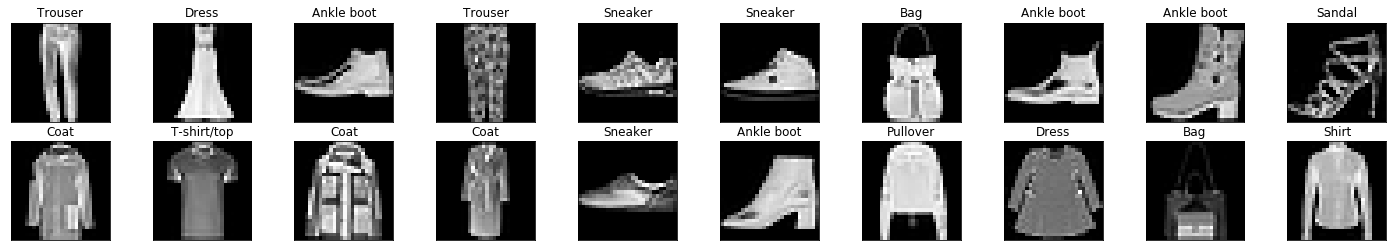

In [18]:
import numpy as np
import matplotlib.pyplot as plt
 
%matplotlib inline
     
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
 
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### 更详细地查看图像
该数据集中的每个图像都是28x28像素且已归一化的灰度图像。

#### 关于归一化的说明
归一化可以确保在训练CNN的过程中，先后经历前馈与反向传播步骤时，每个图像特征都将落入类似的值范围内，而不是过度激活该网络中的特定层。在前馈步骤期间，该神经网络会接收输入图像并将每个输入像素乘以一些卷积滤波器权重并加上偏差，然后应用一些激活和池化函数。如果没有归一化，反向传播步骤中的计算梯度将会非常大，并且会导致我们的损失增加而不是收敛。

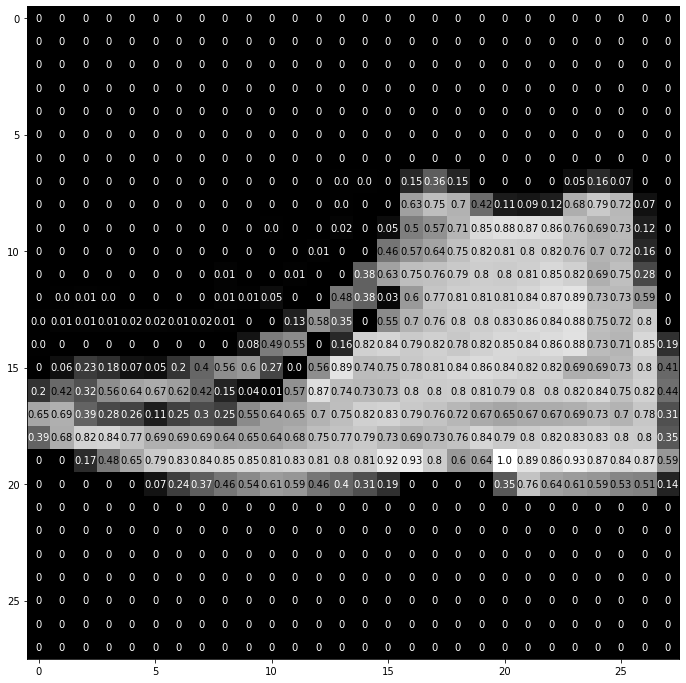

In [19]:
# select an image by index
idx = 2
img = np.squeeze(images[idx])
 
# display the pixel values in that image
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## pytorch进行分类
下面分别使用全连接网络和CNN网络来进行分类
（1）FC网络
输入图像大小为28x28，设计如下全连接网络，代码命名为02_fashion_mnist_fc.py

FC1(784) + Relu(1000) + FC2(500) + Relu + FC3(200) + Relu3 + FC4(10) + log_softmax

In [20]:
from __future__ import print_function   # 从future版本导入print函数功能
import argparse                         # 加载处理命令行参数的库
import torch                            # 引入相关的包
import torch.nn as nn                   # 指定torch.nn别名nn
import torch.nn.functional as F         # 引用神经网络常用函数包，不具有可学习的参数
import torch.optim as optim
from torchvision import datasets, transforms  # 加载pytorch官方提供的dataset

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 1000) # 784表示输入神经元数量，1000表示输出神经元数量
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 200)
        self.fc4 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)  #Applies a softmax followed by a logarithm, output batch * classes tensor

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)       # negative log likelihood loss(nll_loss), sum up batch cross entropy
        loss.backward()
        optimizer.step()                        # 根据parameter的梯度更新parameter的值
        #print(epoch, batch_idx, type(batch_idx))
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():       #无需计算梯度
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./fashionmnist_data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./fashionmnist_data/', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)   #optimizer存储了所有parameters的引用，每个parameter都包含gradient
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12, 24], gamma=0.1)   #学习率按区间更新

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)

    if (args.save_model):
        torch.save(model.state_dict(), "mnist_fc.pt")

# 当.py文件直接运行时，该语句及以下的代码被执行，当.py被调用时，该语句及以下的代码不被执行
if __name__ == '__main__':
    main()

usage: ipykernel_launcher.py [-h] [--batch-size N] [--test-batch-size N]
                             [--epochs N] [--lr LR] [--momentum M] [--no-cuda]
                             [--seed S] [--log-interval N] [--save-model]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Sumner\AppData\Roaming\jupyter\runtime\kernel-8a0cbdc5-06ae-4de5-8d75-ae58c0023f3d.json


SystemExit: 2

d:\programdata\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
